<a href="https://colab.research.google.com/github/rges-pit/minicourses/blob/main/chapter4/extra_material/Day_4_homework_fit_GLplanetary_event.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font face="Helvetica" size="7"> Chapter 4: Binary-lens fitting </font>  

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

<i> Authors: Katarzyna Kruszyńska, Amber Malpas, Etienne Bachelet, Somayeh Khakpash, Ali Crisp </i>

<br>

> <font face="Helvetica" size="5"> **!! WARNING !!**
>
> Work in progress! This notebook doesn't function as intended at the time of writing this comment!

<br>

If you would like an introduction to python notebooks, please read this tutorial: https://medium.com/codingthesmartway-com-blog/getting-started-with-jupyter-notebook-for-python-4e7082bd5d46

Please note, you must **save this notebook in a space owned by you** (a GitHub repo, gist, to Google Drive, or locally) if you want to come back to it later without losing your progress. You can edit and run this notebook on Colab, but it **will not auto save** for you.

### <font face="Helvetica" size="5"> Running locally and local runtimes </font>

*Ignore this section if you already did these steps for another notebook.*

If you choose to use lcoal resources your notebook will use your local packages, so you should install a virtual environment with the following packages. Run the cell below to create a downloadable `.yml` file, to automate the package install process (provided you are using anaconda). Failing that, you can download it from the [git repository](https://github.com/rges-pit/minicourses.git).

In [ ]:
# @title `.yml`
yaml = '''name: minicourse
channels:
  - conda-forge
dependencies:
  - python=3.11
  - numpy
  - matplotlib
  - pandas
  - scipy
  - jupyter
  - ipython
  - astropy
  - beautifulsoup4
  - lxml              # required parser for bs4
  - pip
  - pip:
      - pathos
      - MulensModel
      - pyLIMA'''

# save the yaml
with open('environment.yml', 'w') as f:
    f.write(yaml)

Click the folder button on the side bar to open the file explorer. The file `environment.yml` should be in there now. Just click the triple dots on the side and then `Download` to download the `.yml` file.

```bash
conda env create -f environment.yml
```

Running the above line in a terminal (Anaconda Prompt on Windows) will create a virtual conda environment called `minicourse`, which has the required packages installed.

You can activate the environment with:

```bash
conda activate minicourse
```

From here you have two options

1. You can open the notebook running
```bash
jupyter notebook
```
from a parent folder to your locally saved version of this notebook and navigating to the notebook in your browser. You may need to select `minicourse` as your kernel before running the notebook.

2. Alternatly, you can create a local "Runtime" and for your Colab notebook by following [these instructions](https://www.google.com/url?q=https%3A%2F%2Fresearch.google.com%2Fcolaboratory%2Flocal-runtimes.html).
```bash
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --no-browser
```

  ⚠️ We don't generally recommend that you do this with notebooks that you didn't write as it give them access to your local machine

### <font face="Helvetica" size="5"> Clone the rges-pit/minicourses repo </font>

Do this weather you are running locally or on the cloud, if you do not already have the repo cloned. It has necessary data.

In [ ]:
# #@title Clone the rges-pit/minicourses repo
!git clone https://github.com/rges-pit/minicourses

Cloning into 'minicourses'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 522 (delta 72), reused 76 (delta 65), pack-reused 427 (from 1)
Receiving objects: 100% (522/522), 82.11 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Updating files: 100% (173/173), done.


In [ ]:
!ls -a ./minicourses/
%cd minicourses/
!git status

.   chapter1  chapter3	chapter5  .gitignore  README.md
..  chapter2  chapter4	.git	  LICENSE     trials
/content/minicourses
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [ ]:
!git pull
!git status

Already up to date.
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


## <font face="Helvetica" size="5"> 1. Introduction </font>  

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Welcome to **Chapter 4: Extra material - Binary-lens fitting**.

In this notebook, we will show you how to fit a binary model to a planetary event using your event from Day 4 class.

### <font face="Helvetica" size="4"> 1.1 Load Packages </font>



In [ ]:
#@title Install `pyLIMA`

# you need to run this cell if you are using a cloud runtime on colab
!pip install --default-timeout=100 pyLIMA

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.4/444.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os,sys
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec

from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.parallax import parallax

from pyLIMA.fits import LM_fit
from pyLIMA.models import PSPL_model, USBL_model
from pyLIMA.models import pyLIMA_fancy_parameters

from pyLIMA.outputs import pyLIMA_plots

import multiprocessing as mul

# matplotlib widged doesn't work in Google Collab :(
# uncomment this if you aren't on colab
#%matplotlib widget

### <font face="Helvetica" size="4"> 1.2 `pyLIMA` vs `MulensModel` </font>

In this excersise, you will learn how to use the [**`pyLIMA` package**](https://github.com/ebachelet/pyLIMA) to fit a binary microlensing event.

First let's load the data.

## <font face="Helvetica" size="5"> 2. Load data </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Use the same event (number) you have used during the class.

In [ ]:
##########################
# Put in your number here
my_number = 1
##########################
data = np.loadtxt('chapter4/data/roman_w146_%02d.dat'%my_number)

(2459860.0, 2459880.0)

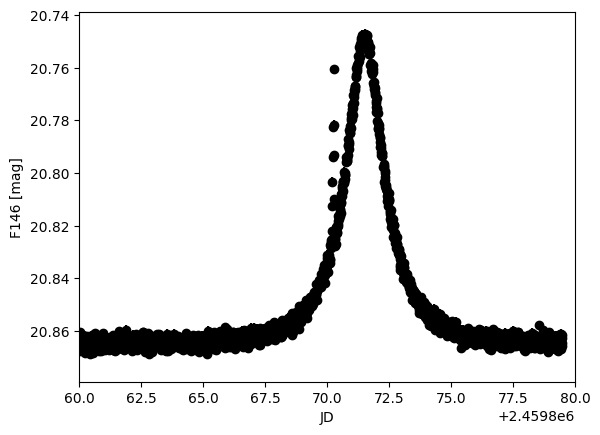

In [ ]:
## Lets have a look at the data
fig = plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], marker='o', color='black', ls='');
plt.gca().invert_yaxis();
plt.xlabel('JD');
plt.ylabel('F146 [mag]');
#plt.xlim(2459860, 2459880)

## <font face="Helvetica" size="5"> 3. Set-up the `Event` object </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

First we will set up the event.

This is similar to `MulensModel`. If we would like to fit with the parallax model, we would also have to specify the coordinates of the event when we define it like this:

`my_event = event.Event(ra=Right Ascension of the event, dec=Declination of the event)`.

In our case, however, we will not fit parallax.

In [ ]:
my_event = event.Event(ra=0.1, dec=0.1)
my_event.name = 'Simulated_Roman_event_%02d'%my_number

### <font face="Helvetica" size="4"> 3.1 Add the data </font>

Then we will add the data

We will use the `telescope` class to do that. We will not include the parallax effect, but if you'd like, we explain how to specify if your observatory is on Earth or in Space.

If you have a mix of ground- and space based observatories and include parallax , you can specify the observatory's location by the `location` key word. The Roman observatory is located in space (hence `Space` value for that key word). The `space_craft` name would indicate the spacecraft's name that **`pyLIMA`** recognizes and knows how to translate to the [**JPL Horizon**](https://ssd.jpl.nasa.gov/)'s spacecraft code. In this case, however, the code for Roman doesn't exist yet. We will therfore use the L2 point as the best proxy.

In [ ]:
telescope = telescopes.Telescope(name='Roman',
                                 lightcurve=data,
                                 lightcurve_names=['time','mag','err_mag'],
                                 lightcurve_units=['JD','mag','mag'],
                                #  location = 'Space', spacecraft_name = 'L2'
                                 )

my_event.telescopes.append(telescope)

### <font face="Helvetica" size="4"> 3.2 Initial guess from your parameter estimates </font>

Before we set up the model, lets put in the parameters you found using the analytical equations.

In [ ]:
t_0 = 2459871.5
u_0 = 0.8
t_E = 4.
rho = 0.01
s = 1
q = 0.001
alpha = 1.67

# We will also need some parameters in log_10, because
# it's easier to probe their parameter space that way
log_t_E = np.log10(t_E)
log_rho = np.log10(rho)
log_s = np.log10(s)
log_q = np.log10(q)

## <font face="Helvetica" size="5"> 4. Set-up the model object </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Now we will set up the model. We will probe the time scale $t_E$, source radius $\rho$, separation $s$, and mass ratio $q$ in log space. This way, we will be able to probe the parameter space more efficiently. To do that in **`pyLIMA`**, we will use the `pyLIMA_fancy_parameters` function.

In [ ]:
fancy = pyLIMA_fancy_parameters.StandardFancyParameters()

We can now set up the model. We will use the uniform source-binary lens model (USBL), and we will force **`pyLIMA`** to not fit parallax. To do that, we will specify the `parallax` keyword. The first one relates to the type of parallax effect we want to fit: in our case, it's `None`. Other options are Full, `Annual`, or `Terrestrial`, when dealing with space-based (first one), or ground-based observatories only (last two). When fitting parallax, we also have to specify the $t_{0,\text{par}}$ parameter, like in **`MulensModel`**. In our case, we will set it to 0. In case you'd like to fit parallax, you should choose one close to the time of closest approach, $t_0$.

In [ ]:
usbl = USBL_model.USBLmodel(my_event, fancy_parameters=fancy, parallax=['None', 0.], blend_flux_parameter='noblend')

## <font face="Helvetica" size="5"> 5. Fitting with `pyLIMA` </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Finally, we can set up our fitting method. `pyLIMA` ofers several different methods. We will use one of the fastest ones, `LM_fit` which is an implementation of [**Levenberg-Marquardt algorithm**](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm).

Other options you could use are:
- `TRF_fit` - [**Trust Region**](https://en.wikipedia.org/wiki/Trust_region) Reflective algorithm;
- `DE_fit` - a [**Differential Evolution**](https://en.wikipedia.org/wiki/Differential_evolution) algorithm to optimize our parameters (here more about [**the implementation in scipy**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html), which **`pyLIMA`** uses);
- `MCMC_fit` - a [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) method, using [**`emcee` package**](https://emcee.readthedocs.io/en/stable/).

Words of caution: `DE_fit` and `MCMC_fit` probe the parameter space, and will take consideribly longer than `LM_fit` and `TRF_fit`.

In [ ]:
lm_fit = LM_fit.LMfit(usbl)

We will also use the fruits of your hard work! Instead of starting with a set of random parameters, we will use parameters that you found earlier to start our search.

In [ ]:
# parameters: t_0, u_0, log(t_E), log(rho), log(s), log(q), alpha, pi_EN, pi_EE,
lm_fit.model_parameters_guess = [t_0, u_0, log_t_E,
                                 log_rho, log_s, log_q,
                                 alpha
                                 ]

We also need to set up boundries for our parameter space. For now, edit the `t_start` and `t_end` parameters to reflect the time when the events are happening. You can leave the other parameter bounries as is.

In [ ]:
t_start = 2459800.
t_end = 2459880.

#Boundries
lm_fit.fit_parameters['t0'][1] = [t_start, t_end]
lm_fit.fit_parameters['u0'][1] = [0., 1.]
lm_fit.fit_parameters['log_tE'][1] = [-1., 3.]
lm_fit.fit_parameters['log_rho'][1] = [-4., 1.]
lm_fit.fit_parameters['log_separation'][1] = [-3., 1.]
lm_fit.fit_parameters['log_mass_ratio'][1] = [-5., 1.]
lm_fit.fit_parameters['alpha'][1] = [0.0, 2.*np.pi]

lm_fit.priors_parameters['t0'][1] = [t_start, t_end]
lm_fit.priors_parameters['u0'][1] = [0., 1.]
lm_fit.priors_parameters['log_tE'][1] = [-1., 3.]
lm_fit.priors_parameters['log_rho'][1] = [-4., 1.]
lm_fit.priors_parameters['log_separation'][1] = [-3., 1.]
lm_fit.priors_parameters['log_mass_ratio'][1] = [-5., 1.]
lm_fit.priors_parameters['alpha'][1] = [0.0, 2.*np.pi]

Finally, we can run our optimizer. This will take a while!

If it takes too long, try to change the boundries for other parameters.

In [ ]:
lm_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [2459871.5, 0.8, 0.6020599913279624, -2.0, 0.0, -3.0, 1.67, 411.2728294275437]


/usr/local/lib/python3.11/dist-packages/pyLIMA/fits/LM_fit.py:99: RuntimeWarning: divide by zero encountered in log10
  scaling = 10 ** np.floor(np.log10(np.abs(self.guess))) + 1
/usr/local/lib/python3.11/dist-packages/pyLIMA/models/pyLIMA_fancy_parameters.py:25: RuntimeWarning: overflow encountered in scalar power
  return 10 **fancy_params['log_rho']


## <font face="Helvetica" size="5"> 6. Fit results </font>

<hr style="border: 1.5pt solid #a859e4; width: 100%; margin-top: -10px;">

Let's display our output. You will also see a couple of files appearing in the directory, which contain the results of your fit, that you can use for an analysis!

Does the model fit well?

In [ ]:
lm_fit.fit_outputs(bokeh_plot=True)